In [1]:
%load_ext tensorboard
import datetime

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.losses as losses
import tensorflow.keras.optimizers as optimizers

import tensorflow_datasets as tfds

In [2]:
NUM_CLASSES = 2
SCALE = 2

In [3]:
from model import bisenetv2_compiled, bisenetv2_output_shape, INPUT_SHAPE

OUTPUT_SHAPE = bisenetv2_output_shape(NUM_CLASSES, SCALE)
m = bisenetv2_compiled(num_classes=NUM_CLASSES, out_scale=SCALE)

In [4]:
m.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 1024, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 512, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 512, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 512, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [5]:
cityscapes = tfds.load('cityscapes/semantic_segmentation')

In [7]:
from data_prep import cityscapes_prep, class_map_road

train_ds = cityscapes['train'].map(cityscapes_prep(OUTPUT_SHAPE, class_map_road))
valid_ds = cityscapes['validation'].map(cityscapes_prep(OUTPUT_SHAPE, class_map_road))

In [8]:
def display_segmentation(pred):
    img = tf.argmax(pred, axis=-1)
    img = img[..., tf.newaxis]
    return tf.keras.preprocessing.image.array_to_img(img)

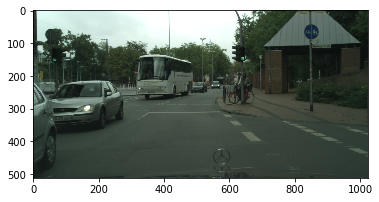

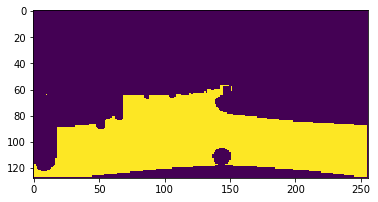

In [9]:
example = list(valid_ds.take(1))[0]
plt.imshow(example[0])
plt.show()

plt.imshow(display_segmentation(example[1]))

In [10]:
BATCH_SIZE = 4

train_ds = train_ds.batch(BATCH_SIZE).prefetch(150)
valid_ds = valid_ds.batch(BATCH_SIZE).prefetch(150)

In [ ]:
EPOCHS = 10

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = m.fit(train_ds,
                validation_data=valid_ds,
                epochs=EPOCHS,
                callbacks=[tensorboard_callback])

Epoch 1/10
  4/744 [..............................] - ETA: 9:53 - loss: 3.4614 - accuracy: 0.3339 

In [39]:
#m.save('model.tf')
m.save('model2.tf')

INFO:tensorflow:Assets written to: model2.tf/assets


INFO:tensorflow:Assets written to: model2.tf/assets


In [19]:
test_ds = cityscapes['test'].map(prep_data)

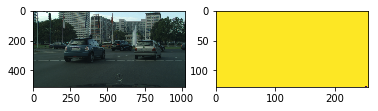

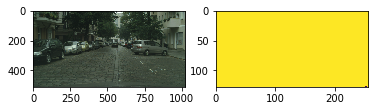

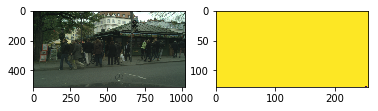

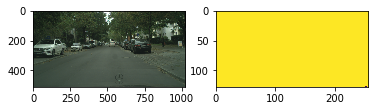

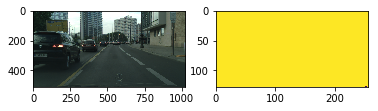

In [20]:
for sample in test_ds.take(5):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    pred = m.predict(tf.expand_dims(sample[0], axis=0))[0]
    ax1.imshow(sample[0])
    ax2.imshow(display_segmentation(pred))